# ANN Model Training Using Validation Set (Regression)


- For ANN modeling (or other ML algorithms)  we typically partition the dataset into three parts: a training set (say, 60%), a validation set (e.g. 20%) and a test set (e.g. 20%). Normally, you are training the network with the training set to adjust the weights. To make sure you don't overfit the network and also fine-tune models you need to input the validation set to the network and check if the error is within some range (This set is not being using directly to adjust the weights but used to give the optimal number of hidden units or determine a stopping point for the back-propagation algorithm). Finally, the accuracy of the model on the test data gives a realistic estimate of the performance of the model on completely unseen data and in order to confirm the actual predictive power of the network.

 <u>To summarize all :</u>
* <b>Training set</b>  --> to fit the parameters [i.e., weights]
* <b>Validation set</b> --> to tune the parameters [i.e., architecture]
* <b>Test set</b> --> to assess the performance [i.e., generalization and predictive power]

## 1) Importing the Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time

## 2) Checking for GPU availability

In [0]:
torch.cuda.is_available()

True

## 3) Creating the dataset 

Here, in the beginning we are creating our own datasets. Later on, we will be using datasets from kaggle

In [0]:
#Feature
X = torch.linspace(1,10000,10000)

#noise
noise = np.random.randint(-10,10,10000)

#Label
y = 5*X + noise

X = X.reshape(-1,1).cuda()
y = y.reshape(-1,1).cuda()

len(X), len(y), X.shape, y.shape , type(X), type(y)

(10000,
 10000,
 torch.Size([10000, 1]),
 torch.Size([10000, 1]),
 torch.Tensor,
 torch.Tensor)

## 4) Dividing the dataset

Normally there are 2 ways to divide the dataset :
- Using Scikit learn (train_test_split)
- Using Pytorch ( DataLoader and TensorDataset)

But these will divide your dataset into only 2 parts(train and test). Here,we want validation set as well. So,lets divide the dataset by ourself.

We will train on 80% data, will use 10% for validation and the remaining for testing

In [0]:
size = int(0.8*len(X))
X_train, y_train = X[:size] , y[:size]
X_val, y_val = X[size:size+int(0.1*len(X))], y[size:size+int(0.1*len(X))]
X_test, y_test = X[size+int(0.1*len(X)):], y[size+int(0.1*len(X)):]

len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(8000, 8000, 1000, 1000, 1000, 1000)

## 5) ANN model

In [0]:
class ANN(nn.Module):
  def __init__(self,in_features,out_features,hidden_neurons,n_layers = 3):
    super().__init__()

    self.in_features = in_features
    self.hidden_neurons = hidden_neurons
    self.out_features = out_features

    layer_list = []
    layer_list.append(nn.Linear(self.in_features,self.hidden_neurons))
    layer_list.append(nn.Linear(self.hidden_neurons,self.hidden_neurons))
    layer_list.append(nn.Linear(self.hidden_neurons,self.out_features))

    self.layers = nn.Sequential(*layer_list)

  def forward(self,X):

    y_pred = self.layers(X)
    return y_pred

## 6) Initialising the ANN model

In [0]:
model = ANN(1,1,256,2)
gpu_model = model.cuda()
gpu_model

ANN(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)

## 7) Loss function and optimizer

In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

## 8) Training the model

Here, we will be training the model on X_train set and simultenously checking it on validation set.

In [0]:
epochs = 200
losses = []

gpu_model.train()

for i in range(epochs):
  i+=1

  ####### Training #######

  y_pred = gpu_model(X_train)

  loss = criterion(y_train,y_pred)
  losses.append(loss)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if i%25 == 0:

    ####### Validation #########

    gpu_model.eval()
    y_val_pred = gpu_model(X_val)
    losse = criterion(y_val,y_val_pred)

    print(f'Epoch : {i} Loss : {losse.item()}')

    gpu_model.train()

Epoch : 25 Loss : 29102668.778937493
Epoch : 50 Loss : 868014.1380434292
Epoch : 75 Loss : 109482.30662011319
Epoch : 100 Loss : 15103.039376535531
Epoch : 125 Loss : 2093.999352313021
Epoch : 150 Loss : 134.92826136785467
Epoch : 175 Loss : 44.75182011876136
Epoch : 200 Loss : 33.381890150618105


Here, we are going for evaluation of validation set.All depends on the loss function. If you want to decrease it, go for manual hyperparameter tuning.

## 9) Predicting the result on the Test Set

In [0]:
with torch.no_grad():
  y_test_pred = gpu_model(X_test)
  loss = criterion(y_test,y_test_pred)
  print(loss.item())


33.14591844446376


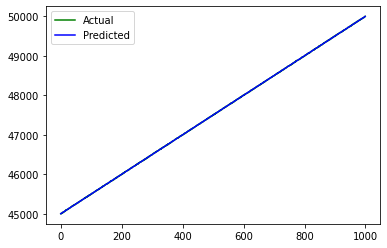

In [0]:
plt.plot(y_test.cpu().numpy().flatten(),'g',label = 'Actual')
plt.plot(y_test_pred.cpu().numpy().flatten(),'b' , label = 'Predicted')
plt.legend()

In [0]:
df = pd.DataFrame(y_test.cpu().numpy())
df['Predicted'] = y_test_pred.cpu().numpy()
df.rename(columns= {0 : 'Actual'},inplace= True)
df

,Actual,Predicted
0,45005.0,45005.121094
1,45000.0,45010.121094
2,45010.0,45015.121094
3,45015.0,45020.125000
4,45017.0,45025.121094
...,...,...
995,49977.0,49980.175781
996,49978.0,49985.171875
997,49980.0,49990.175781
998,49998.0,49995.175781


#